In [ ]:
# upgrage tensorflow and install requirements
!pip uninstall -y tensorflow-io
!pip uninstall -y tensorflow-transform
!pip uninstall -y tensorflow-cloud
!pip uninstall -y tfx-bsl
!pip uninstall -y tensorflow
!pip install tensorflow
!pip install segmentation_models
import os
!sudo apt install -y --allow-change-held-packages libcudnn8
os._exit(00)

In [4]:
import os
import cv2
import numpy as np
import segmentation_models as sm
import random

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
kaggle_path = '/kaggle/input/satelliteimagesegmentation/'

[0 6]


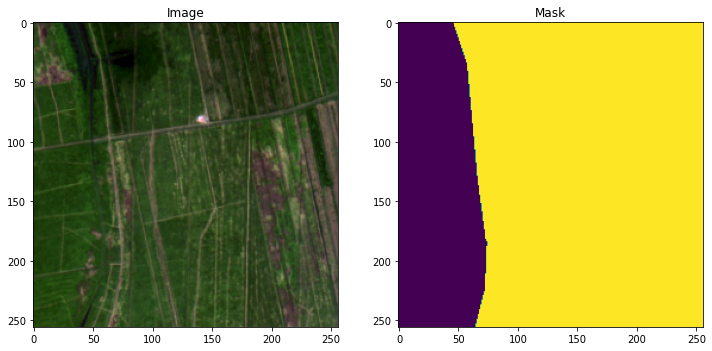

In [37]:
train_img_dir = kaggle_path + "data/data_for_keras_aug/train_images/train/"
train_mask_dir = kaggle_path + "data/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

img_list.sort()
msk_list.sort()

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images - 1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='viridis')
print(np.unique(mask_for_plot))
plt.title('Mask')
plt.show()

In [38]:
BACKBONE = 'seresnext50'
preprocess_input = sm.get_preprocessing(BACKBONE)
batch_size = 64
seed = 42
n_classes = 14
# scaler = MinMaxScaler()

In [39]:
def preprocess_data(img, mask, num_class):
    #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    
    mask[mask == 7] = 6
    
    for i in range(8,16):
        mask[mask==i] = i - 1
    
    mask[mask == 13] = 12
    mask[mask == 14] = 13
    mask = to_categorical(mask, num_class)
    
    return (img, mask)

In [40]:
def trainGenerator(train_img_path, train_mask_path, num_class, aug=True):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    if aug:
        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [41]:
train_img_path = kaggle_path + "data/data_for_keras_aug/train_images/"
train_mask_path = kaggle_path + "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = kaggle_path + "data/data_for_keras_aug/val_images/"
val_mask_path = kaggle_path + "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

In [ ]:
def show_examples(generator):
    x, y = generator.__next__()
    for i in range(0,3):
        image = x[i]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.argmax(y[i], axis=2)
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask, cmap='viridis')
        plt.show()
    return x, y

x, y = show_examples(train_img_gen)
x_val, y_val = show_examples(val_img_gen)

In [42]:
num_train_imgs = len(os.listdir(train_img_path + "/train"))
num_val_images = len(os.listdir(val_img_path + "/val"))

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

In [43]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                     classes=n_classes, activation='softmax')
    model.compile('Adam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.iou_score])

104679448/104679448 [==============================] - 6s 0us/step


In [ ]:
mkdir tmp

In [28]:
cd tmp

/kaggle/working/tmp


In [ ]:
os.system(f'mkdir {BACKBONE}_14classes/')

In [30]:
#model.load_weights(f'{BACKBONE}_14classes.h5')

In [ ]:
checkpoint_filepath = f'{BACKBONE}_14classes/checkpoint'
# model.load_weights(checkpoint_filepath)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq = 10,
    save_best_only=True,
    monitor=sm.metrics.iou_score,
    mode='max')

model.fit(train_img_gen,
                steps_per_epoch=steps_per_epoch,
                epochs=25,
                verbose=1,
                validation_data=val_img_gen,
                validation_steps=val_steps_per_epoch,
                callbacks=[model_checkpoint_callback])

In [48]:
 model.save_weights(f'{BACKBONE}_14classes.h5')

In [ ]:
def get_raw_image(train_img_path, aug=True):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    if aug:
        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)   
    
    for raw_img in image_generator:
        yield raw_img
        
raw_img_gen = get_raw_image(val_img_path, aug=False)

In [ ]:
import matplotlib.patches as mpatches

test_image_batch, test_mask_batch = val_img_gen.__next__()
raw_image_batch = raw_img_gen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

img_num = random.randint(0, test_image_batch.shape[0]-1)

print(np.unique(test_mask_batch_argmax[img_num]))
print(np.unique(test_pred_batch_argmax[img_num]))


fig, ax = plt.subplots(1, 4)
fig.set_figheight(15)
fig.set_figwidth(15)


combined_data = np.array(list(np.unique(test_mask_batch_argmax[img_num])) + \
                         list(np.unique(test_pred_batch_argmax[img_num])))
#Get the min and max of all your data
_min, _max = np.amin(combined_data), np.amax(combined_data)



img_for_plot = cv2.imread(raw_image_batch[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

ax[0].imshow(img_for_plot)
ax[1].imshow(test_image_batch[img_num], interpolation='none')


values = np.unique(test_mask_batch_argmax[img_num])
im = ax[2].imshow(test_mask_batch_argmax[img_num], cmap='viridis', vmin = _min, vmax = _max)
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label="Class {l}".format(l=values[i])) \
                                                    for i in range(len(values))]
ax[2].legend(handles=patches)


values = np.unique(test_pred_batch_argmax[img_num])
im = ax[3].imshow(test_pred_batch_argmax[img_num], vmin = _min, vmax = _max)
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label="Class {l}".format(l=values[i])) \
                                                    for i in range(len(values))]
ax[2].legend(handles=patches)

plt.show()